# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import round, sum, avg,count, countDistinct, col, concat, desc, explode, last, lit, min, max, split, udf, when, isnan
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import re

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Datascience Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
event_data = spark.read.json("mini_sparkify_event_data.json")
#event_data = spark.read.json("medium-sparkify-event-data.json")

In [5]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
event_data = event_data.where(col('userId') != '')

In [9]:
event_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in event_data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [10]:
event_data.where(event_data.song.isNull()).select(event_data.page).distinct().show(100)
# This is due to the fact that only when the users click on NextSong, there is an Artist/Length or Song saved in the database

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [11]:
event_data.where(event_data.song.isNotNull()).select(event_data.page).distinct().show(100)

+--------+
|    page|
+--------+
|NextSong|
+--------+



We still have null values on artist, song and length because in those cases the action of the user was not related to a song, as shown in the previous cell.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [12]:
event_data.summary().show()

+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|   278154|   278154|278154|            278154|  278154|           228108|278154|           278154|278154| 278154|             

In [13]:
event_data.select("song", "length", "level", "itemInSession").summary().show()

+-------+--------------------+-----------------+------+------------------+
|summary|                song|           length| level|     itemInSession|
+-------+--------------------+-----------------+------+------------------+
|  count|              228108|           228108|278154|            278154|
|   mean|            Infinity|249.1171819778458|  null|114.89918174824018|
| stddev|                 NaN|99.23517921058361|  null|  129.851729399489|
|    min|ÃÂg ÃÂtti Gr...|          0.78322|  free|                 0|
|    25%|                24.0|        199.88853|  null|                27|
|    50%|               221.0|        234.50077|  null|                70|
|    75%|              1958.0|        277.15873|  null|               157|
|    max|ÃÂau hafa slopp...|       3024.66567|  paid|              1321|
+-------+--------------------+-----------------+------+------------------+



In [14]:
event_data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [15]:
print("Number of rows of this subset: ")
event_data.count()

Number of rows of this subset: 


278154

In [16]:
print("Number of Users in this subset: ")
event_data.select("userId").distinct().count()

Number of Users in this subset: 


225

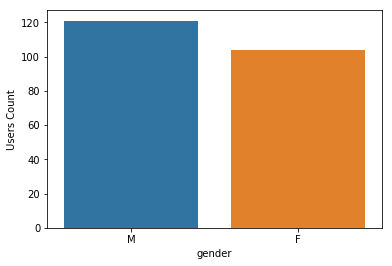

In [17]:
gender_count = event_data.groupby('gender').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc())
sns.barplot(x='gender',y='Users Count',data=gender_count.toPandas());

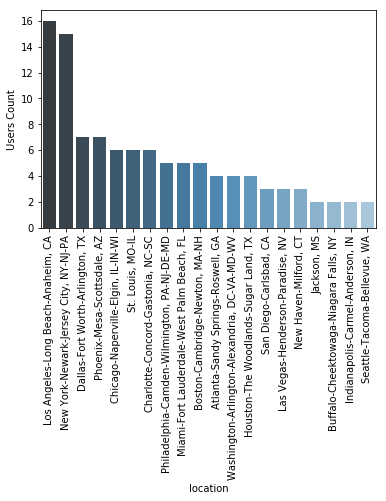

In [18]:
location_count = event_data.groupby('location').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).limit(20)
location_plot = sns.barplot(x='location',y='Users Count',data=location_count.toPandas(), palette="Blues_d")
for item in location_plot.get_xticklabels():
    item.set_rotation(90)

In [19]:
print("List of different types of pages: ")
event_data.select(['page']).sort('page').distinct().show(23, False)

List of different types of pages: 
+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [20]:
print("Number of sessions per user, ordered by sessions count: ")
event_data.groupby('userId').agg(count("sessionId").alias("sessionId Count")).sort(col('sessionId Count').desc()).show()

Number of sessions per user, ordered by sessions count: 
+------+---------------+
|userId|sessionId Count|
+------+---------------+
|    39|           9632|
|    92|           7230|
|   140|           6880|
|300011|           5732|
|   124|           4825|
|300021|           4659|
|300017|           4428|
|    85|           4370|
|    42|           4257|
|200023|           3769|
|     6|           3761|
|    29|           3603|
|    54|           3437|
|   100|           3214|
|     9|           3191|
|   126|           3102|
|300015|           3051|
|    91|           3014|
|    98|           2891|
|    74|           2887|
+------+---------------+
only showing top 20 rows



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [21]:
churn_flag = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

event_data = event_data.withColumn("churn_flag", churn_flag('page'))

user_window = Window \
    .partitionBy('userId')

event_data = event_data.withColumn("churn", max(event_data.churn_flag).over(user_window))

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [22]:
event_data.groupby('churn').agg(countDistinct('userId').alias("Users Count")).show()

+-----+-----------+
|churn|Users Count|
+-----+-----------+
|    1|         52|
|    0|        173|
+-----+-----------+



In [23]:
event_data.groupby('gender', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+------+-----+-----------+
|gender|churn|Users Count|
+------+-----+-----------+
|     M|    0|         89|
|     F|    0|         84|
|     M|    1|         32|
|     F|    1|         20|
+------+-----+-----------+



In [24]:
event_data.groupby('level', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+-----+-----+-----------+
|level|churn|Users Count|
+-----+-----+-----------+
| free|    0|        149|
| paid|    0|        129|
| free|    1|         46|
| paid|    1|         36|
+-----+-----+-----------+



The same user can pass from free to paid or from paid to free, so the total counts exceed the total number of users in the dataset

In [25]:
event_data.groupby('auth', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+---------+-----+-----------+
|     auth|churn|Users Count|
+---------+-----+-----------+
|Logged In|    0|        173|
|Cancelled|    1|         52|
|Logged In|    1|         52|
+---------+-----+-----------+



Of course the users who churned are not anymore logged in and they end up in "Cancelled" type of authentication

In [26]:
event_data.groupby('status', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+------+-----+-----------+
|status|churn|Users Count|
+------+-----+-----------+
|   200|    0|        173|
|   307|    0|        171|
|   404|    0|         95|
|   307|    1|         52|
|   200|    1|         52|
|   404|    1|         22|
+------+-----+-----------+



Ratio for Users Count churn or not-churn does not seem to be affected by status

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Categorical Features

In [27]:
event_data_agg = event_data.select(["userId", "gender"]).distinct()

stringIndexer = StringIndexer(inputCol="gender", outputCol="genderIndexed")
stringIndexer = stringIndexer.fit(event_data_agg)
event_data_agg = stringIndexer.transform(event_data_agg)
   
encoder = OneHotEncoder(inputCol="genderIndexed", outputCol="genderFeature")
event_data_agg_cat = encoder.transform(event_data_agg)

In [28]:
event_data_agg_cat.show(10)

+------+------+-------------+-------------+
|userId|gender|genderIndexed|genderFeature|
+------+------+-------------+-------------+
|    44|     F|          1.0|    (1,[],[])|
|    46|     F|          1.0|    (1,[],[])|
|    41|     F|          1.0|    (1,[],[])|
|    72|     F|          1.0|    (1,[],[])|
|300023|     F|          1.0|    (1,[],[])|
|    39|     F|          1.0|    (1,[],[])|
|100010|     F|          1.0|    (1,[],[])|
|    40|     F|          1.0|    (1,[],[])|
|    94|     F|          1.0|    (1,[],[])|
|    35|     F|          1.0|    (1,[],[])|
+------+------+-------------+-------------+
only showing top 10 rows



In [29]:
event_data_agg_cat.count()

225

#### Side note on data leakage

In [30]:
# it would be useful to use the last value of level
spec = Window\
    .partitionBy('userId')\
    .orderBy(col('ts').desc())\
    .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

event_data_agg_1 = event_data.withColumn('lastLevel', last('level').over(spec)).select(['userId', 'lastLevel']).distinct()

### Numerical Features

In [31]:
#count of page actions for each uers
event_data_agg_2 = event_data.groupby('userId').pivot('page').count()
event_data_agg_2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in event_data_agg_2.columns]).show()

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|     0|   70|        19|             10|   173|                      173|       71|  108|  33|   2|    12|       0|         18|           93|      30|             176|            94|         22|        5|     57|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--

In [32]:
event_data_agg_2.show()

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|200002|    3|         4|              8|  null|                     null|        5| null|   2|  20|     5|     387|          7|         null|       3|            null|             1|          6|       21|      2|
|100010|    1|         4|              7|  null|                     null|     null| null|   2|  11|     5|     275|         52|         null|  

In [33]:
#replacing null values with 0 as in this case when the count is null, it means the user did not click on that page action
event_data_agg_2 = event_data_agg_2.fillna(0)

In [34]:
#number of sessions per user
event_data_agg_3 = event_data.groupby('userId').agg(count('sessionId').alias('numSessions'))

#number of songs per user
event_data_agg_4 = event_data.groupby('userId').agg(count('song').alias('numSongs'))

#average number of songs per user per session
event_data_agg_5 = event_data.groupby('userId', 'sessionId').agg(count('song').alias('numSongs')).groupby('userId').agg(round(avg('numSongs'), 1).alias('avgSongs'))

In [35]:
event_data_agg_num = event_data_agg_2.join(event_data_agg_3, ['userId'])\
                                     .join(event_data_agg_4, ['userId'])\
                                     .join(event_data_agg_5, ['userId'])

# we cannot use "Cancellation Confirmation"  and "Cancel" as it would result in data leakage, as this information was used to build the churn column
event_data_agg_num = event_data_agg_num.drop("Cancellation Confirmation", "Cancel")

num_features = ["About","Add Friend","Add to Playlist","Downgrade","Error","Help","Home","Logout","NextSong","Roll Advert","Save Settings","Settings","Submit Downgrade","Submit Upgrade","Thumbs Down","Thumbs Up","Upgrade","numSessions","numSongs","avgSongs"]
assembler = VectorAssembler(inputCols=num_features, outputCol="NumFeatures")
event_data_agg_num = assembler.transform(event_data_agg_num)

In [36]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(event_data_agg_num)
event_data_agg_num = scalerModel.transform(event_data_agg_num)

In [37]:
event_data_agg_num.count()

225

### Final Joins

In [38]:
event_data_agg_final = event_data_agg_cat.join(event_data_agg_num, ['userId']).join(event_data.select("userId", "churn").distinct(), ["userId"])

In [39]:
features = event_data_agg_final.drop('userId', 'gender', 'genderIndexed', 'Cancel', 'Cancellation Confirmation', 'NumFeatures', 'ScaledNumFeatures', 'churn')

In [40]:
event_data_final = event_data_agg_final.select(col("churn").alias("label"), col("ScaledNumFeatures"), col("genderFeature"))

assembler2 = VectorAssembler(inputCols=['genderFeature', 'ScaledNumFeatures'], outputCol='all_features')
event_data_final = assembler2.transform(event_data_final)
event_data_final = event_data_final.select(event_data_final.label, event_data_final.all_features.alias('features'))

In [41]:
event_data_final.count()

225

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [65]:
rest, validation = event_data_final.randomSplit([0.8, 0.2], seed=42)

### First model: Logistic Regression

In [66]:
# Defining ML model and pipeline step
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[lr])

In [67]:
# Defining hyper-parameters tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1,]) \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .build()

In [68]:
# Defining evalutation metrics
evaluator = MulticlassClassificationEvaluator(metricName="f1")

In [69]:
# ML pipeline initialization with Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [70]:
# Model fitting
cvModel_lr = crossval.fit(rest)

In [71]:
# Model testing
results = cvModel_lr.transform(validation)
results_rest = cvModel_lr.transform(rest)

In [72]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing
try: 
    precision = ((results.filter((results.label == results.prediction) & (results.label == 1.0)).count())/((results.filter((results.label == results.prediction) & (results.label == 1.0)).count())+(results.filter((results.prediction == 1.0) & (results.label == 0.0)).count())))
    recall = ((results.filter((results.label == results.prediction) & (results.label == 1.0)).count())/((results.filter((results.label == results.prediction) & (results.label == 1.0)).count())+(results.filter((results.prediction == 0.0) & (results.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results.count()))
    print("Accuracy: %s" % ((results.filter(results.label == results.prediction).count())/results.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Precision or Recall could not be computed: division by zero


In [117]:
print("Total count: %s" % (results.count()))
print("Accuracy: %s" % ((results.filter(results.label == results.prediction).count())/results.count()))
print("Precision: 0")
print("Recall: 0")
print("F1-score: 0")

Total count: 34
Accuracy: 0.7058823529411765
Precision: 0
Recall: 0
F1-score: 0


In [73]:
# 1.2: check counts of correct predictions on training 
try:
    precision = ((results_rest.filter((results_rest.label == results_rest.prediction) & (results_rest.label == 1.0)).count())/((results_rest.filter((results_rest.label == results_rest.prediction) & (results_rest.label == 1.0)).count())+(results_rest.filter((results_rest.prediction == 1.0) & (results_rest.label == 0.0)).count())))
    recall = ((results_rest.filter((results_rest.label == results_rest.prediction) & (results_rest.label == 1.0)).count())/((results_rest.filter((results_rest.label == results_rest.prediction) & (results_rest.label == 1.0)).count())+(results_rest.filter((results_rest.prediction == 0.0) & (results_rest.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count_rest: %s" % (results_rest.count()))
    print("Accuracy_rest: %s" % ((results_rest.filter(results_rest.label == results_rest.prediction).count())/results_rest.count()))
    print("Precision_rest: %s" % (precision))
    print("Recall_rest: %s" % (recall))
    print("F1-score_rest: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Precision or Recall could not be computed: division by zero


In [74]:
# Evaluation 2: using f1 to evaluate model
evaluator.evaluate(results)

0.5841784989858012

In [75]:
results.show(86)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[1.0,0.9616499582...|[1.14589793409766...|[0.75876086045273...|       0.0|
|    0|[1.0,0.0,0.048586...|[0.95363130722544...|[0.72184487653589...|       0.0|
|    0|[1.0,0.6410999721...|[1.18621210311993...|[0.76606291750400...|       0.0|
|    1|[1.0,0.3205499860...|[0.96580866154012...|[0.72428328734541...|       0.0|
|    0|(21,[0,3,7,8,9,10...|[0.89656169418908...|[0.71024241756563...|       0.0|
|    0|(21,[2,7,9,10,16,...|[1.14337936734534...|[0.75829955450710...|       0.0|
|    1|[0.0,0.3205499860...|[0.81353323446816...|[0.69286190366246...|       0.0|
|    0|[1.0,3.8465998329...|[2.61994623212367...|[0.93213430514927...|       0.0|
|    1|[1.0,0.0,0.145760...|[0.83083028006615...|[0.69653045955120...|       0.0|
|    0|[0.0,1.60

In [76]:
results_rest.show(100)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.3205499860...|[1.05073199923591...|[0.74091543835142...|       0.0|
|    1|(21,[0,9,10,18,19...|[0.90407397827721...|[0.71178598637890...|       0.0|
|    0|[0.0,2.2438499025...|[2.44660141719536...|[0.92031256352982...|       0.0|
|    1|[1.0,0.6410999721...|[0.99634043669908...|[0.73033845670225...|       0.0|
|    1|[0.0,1.6027499304...|[1.52593881288996...|[0.82141133682417...|       0.0|
|    0|[0.0,0.6410999721...|[1.66015110132598...|[0.84025828556866...|       0.0|
|    0|(21,[2,3,6,7,8,9,...|[1.12555870041125...|[0.75501834197293...|       0.0|
|    0|[0.0,1.2821999443...|[1.85809300065258...|[0.86507451686870...|       0.0|
|    1|[1.0,0.0,0.291520...|[0.88327135648356...|[0.70749966757332...|       0.0|
|    0|[0.0,2.24

In [77]:
bestPipeline = cvModel_lr.bestModel

print('Best parameters : regParam:{}, elasticNetParam:{}'.\
    format(bestPipeline.stages[0].getOrDefault('regParam'), bestPipeline.stages[0].getOrDefault('elasticNetParam')))

Best parameters : regParam:0.1, elasticNetParam:0.0


#### Fine tuning with areaUnderPR score

In [85]:
# Defining ML model and pipeline step
lr1 = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[lr1])

# Defining hyper-parameters tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr1.regParam,[0.0, 0.1]) \
    .addGrid(lr1.elasticNetParam,[0.0, 0.5, 1.0]) \
    .build()

# Defining evalutation metrics
evaluator = BinaryClassificationEvaluator()\
    .setMetricName("areaUnderPR")


# ML pipeline initialization with Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Model fitting
cvModel_lr1 = crossval.fit(rest)

# Model testing
results1 = cvModel_lr1.transform(validation)
results_rest1 = cvModel_lr1.transform(rest)

In [86]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing
try: 
    precision = ((results1.filter((results1.label == results1.prediction) & (results1.label == 1.0)).count())/((results1.filter((results1.label == results1.prediction) & (results1.label == 1.0)).count())+(results1.filter((results1.prediction == 1.0) & (results1.label == 0.0)).count())))
    recall = ((results1.filter((results1.label == results1.prediction) & (results1.label == 1.0)).count())/((results1.filter((results1.label == results1.prediction) & (results1.label == 1.0)).count())+(results1.filter((results1.prediction == 0.0) & (results1.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results1.count()))
    print("Accuracy: %s" % ((results1.filter(results1.label == results1.prediction).count())/results1.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Precision or Recall could not be computed: division by zero


In [87]:
# 1.2: check counts of correct predictions on training 
try:
    precision = ((results_rest1.filter((results_rest1.label == results_rest1.prediction) & (results_rest1.label == 1.0)).count())/((results_rest1.filter((results_rest1.label == results_rest1.prediction) & (results_rest1.label == 1.0)).count())+(results_rest1.filter((results_rest1.prediction == 1.0) & (results_rest1.label == 0.0)).count())))
    recall = ((results_rest1.filter((results_rest1.label == results_rest1.prediction) & (results_rest1.label == 1.0)).count())/((results_rest1.filter((results_rest1.label == results_rest1.prediction) & (results_rest1.label == 1.0)).count())+(results_rest1.filter((results_rest1.prediction == 0.0) & (results_rest1.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count_rest: %s" % (results_rest1.count()))
    print("Accuracy_rest: %s" % ((results_rest1.filter(results_rest1.label == results_rest1.prediction).count())/results_rest1.count()))
    print("Precision_rest: %s" % (precision))
    print("Recall_rest: %s" % (recall))
    print("F1-score_rest: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Precision or Recall could not be computed: division by zero


In [88]:
# Evaluation 2: using f1-score to evaluate model
evaluator.evaluate(results)

0.42320771956801373

In [89]:
results1.show(86)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[1.0,0.9616499582...|[1.30359863947279...|[0.78644000518392...|       0.0|
|    0|[1.0,0.0,0.048586...|[1.17227155008357...|[0.76355536362162...|       0.0|
|    0|[1.0,0.6410999721...|[1.29962178288184...|[0.78577132283951...|       0.0|
|    1|[1.0,0.3205499860...|[1.20012771059779...|[0.76854750172526...|       0.0|
|    0|(21,[0,3,7,8,9,10...|[1.14839224616030...|[0.75921713163157...|       0.0|
|    0|(21,[2,7,9,10,16,...|[1.14839224616030...|[0.75921713163157...|       0.0|
|    1|[0.0,0.3205499860...|[1.22400701452107...|[0.77276794070897...|       0.0|
|    0|[1.0,3.8465998329...|[1.84085573118009...|[0.86304988181193...|       0.0|
|    1|[1.0,0.0,0.145760...|[1.14839224616030...|[0.75921713163157...|       0.0|
|    0|[0.0,1.60

In [90]:
results_rest1.show(100)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.3205499860...|[1.20012771059779...|[0.76854750172526...|       0.0|
|    1|(21,[0,9,10,18,19...|[1.14839224616030...|[0.75921713163157...|       0.0|
|    0|[0.0,2.2438499025...|[1.65381632076241...|[0.83940617023526...|       0.0|
|    1|[1.0,0.6410999721...|[1.27574247895856...|[0.78172418069047...|       0.0|
|    1|[0.0,1.6027499304...|[1.43094887227106...|[0.80704911800421...|       0.0|
|    0|[0.0,0.6410999721...|[1.32350108680511...|[0.78976360639138...|       0.0|
|    0|(21,[2,3,6,7,8,9,...|[1.14839224616030...|[0.75921713163157...|       0.0|
|    0|[0.0,1.2821999443...|[1.42697201568010...|[0.80642908225629...|       0.0|
|    1|[1.0,0.0,0.291520...|[1.14839224616030...|[0.75921713163157...|       0.0|
|    0|[0.0,2.24

In [91]:
bestPipeline = cvModel_lr.bestModel

print('Best parameters : regParam:{}, elasticNetParam:{}'.\
    format(bestPipeline.stages[0].getOrDefault('regParam'), bestPipeline.stages[0].getOrDefault('elasticNetParam')))

Best parameters : regParam:0.1, elasticNetParam:0.0


### Second model: Random Forest

In [92]:
# Defining ML model and pipeline step
rf = RandomForestClassifier(numTrees=10, maxDepth=5)

pipeline = Pipeline(stages=[rf])

In [93]:
# Defining hyper-parameters tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[10, 50]) \
    .addGrid(rf.maxDepth,[5, 15]) \
    .build()

In [94]:
# Defining evalutation metrics
evaluator = BinaryClassificationEvaluator()\
    .setMetricName("areaUnderPR")

In [95]:
# ML pipeline initialization with Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [96]:
# Model fitting
cvModel_rf = crossval.fit(rest)

In [97]:
# Model testing
results_rf = cvModel_rf.transform(validation)
results_rf_rest = cvModel_rf.transform(rest)

In [98]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing 
try:
    precision = ((results_rf.filter((results_rf.label == results_rf.prediction) & (results_rf.label == 1.0)).count())/((results_rf.filter((results_rf.label == results_rf.prediction) & (results_rf.label == 1.0)).count())+(results_rf.filter((results_rf.prediction == 1.0) & (results_rf.label == 0.0)).count())))
    recall = ((results_rf.filter((results_rf.label == results_rf.prediction) & (results_rf.label == 1.0)).count())/((results_rf.filter((results_rf.label == results_rf.prediction) & (results_rf.label == 1.0)).count())+(results_rf.filter((results_rf.prediction == 0.0) & (results_rf.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results_rf.count()))
    print("Accuracy: %s" % ((results_rf.filter(results_rf.label == results_rf.prediction).count())/results_rf.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Precision or Recall could not be computed: division by zero


In [99]:
# 1.2: check counts of correct predictions on training 
try:
    precision = ((results_rf_rest.filter((results_rf_rest.label == results_rf_rest.prediction) & (results_rf_rest.label == 1.0)).count())/((results_rf_rest.filter((results_rf_rest.label == results_rf_rest.prediction) & (results_rf_rest.label == 1.0)).count())+(results_rf_rest.filter((results_rf_rest.prediction == 1.0) & (results_rf_rest.label == 0.0)).count())))
    recall = ((results_rf_rest.filter((results_rf_rest.label == results_rf_rest.prediction) & (results_rf_rest.label == 1.0)).count())/((results_rf_rest.filter((results_rf_rest.label == results_rf_rest.prediction) & (results_rf_rest.label == 1.0)).count())+(results_rf_rest.filter((results_rf_rest.prediction == 0.0) & (results_rf_rest.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count_rest: %s" % (results_rf_rest.count()))
    print("Accuracy_rest: %s" % ((results_rf_rest.filter(results_rf_rest.label == results_rf_rest.prediction).count())/results_rf_rest.count()))
    print("Precision_rest: %s" % (precision))
    print("Recall_rest: %s" % (recall))
    print("F1-score_rest: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count_rest: 191
Accuracy_rest: 0.8586387434554974
Precision_rest: 1.0
Recall_rest: 0.35714285714285715
F1-score_rest: 0.5263157894736842


In [100]:
# Evaluation 2: using areaUnderPR to evaluate model
evaluator.evaluate(results_rf)

0.4393879962001779

In [101]:
results_rf.show(86)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[1.0,0.9616499582...|[7.43741137873156...|[0.74374113787315...|       0.0|
|    0|[1.0,0.0,0.048586...|[7.92128473686520...|[0.79212847368652...|       0.0|
|    0|[1.0,0.6410999721...|[9.32265179078491...|[0.93226517907849...|       0.0|
|    1|[1.0,0.3205499860...|[8.01206575661174...|[0.80120657566117...|       0.0|
|    0|(21,[0,3,7,8,9,10...|[6.30295208332085...|[0.63029520833208...|       0.0|
|    0|(21,[2,7,9,10,16,...|[8.69698326275458...|[0.86969832627545...|       0.0|
|    1|[0.0,0.3205499860...|[5.39285714285714...|[0.53928571428571...|       0.0|
|    0|[1.0,3.8465998329...|[8.72941500091692...|[0.87294150009169...|       0.0|
|    1|[1.0,0.0,0.145760...|[8.74945011154221...|[0.87494501115422...|       0.0|
|    0|[0.0,1.60

In [102]:
results_rf_rest.show(100)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.3205499860...|[7.81586212822332...|[0.78158621282233...|       0.0|
|    1|(21,[0,9,10,18,19...|[5.68528735632183...|[0.56852873563218...|       0.0|
|    0|[0.0,2.2438499025...|[9.95121951219512...|[0.99512195121951...|       0.0|
|    1|[1.0,0.6410999721...|[4.97218415828904...|[0.49721841582890...|       1.0|
|    1|[0.0,1.6027499304...|[5.46919243362914...|[0.54691924336291...|       0.0|
|    0|[0.0,0.6410999721...|[8.37683848388447...|[0.83768384838844...|       0.0|
|    0|(21,[2,3,6,7,8,9,...|[6.57564443404011...|[0.65756444340401...|       0.0|
|    0|[0.0,1.2821999443...|[9.71085054854889...|[0.97108505485488...|       0.0|
|    1|[1.0,0.0,0.291520...|[7.70056122265332...|[0.77005612226533...|       0.0|
|    0|[0.0,2.24

In [103]:
bestPipeline = cvModel_rf.bestModel

# prints feature importances
for i in range(len(bestPipeline.stages[0].featureImportances)):
    print("{}: {} \n".format(features.columns[i], bestPipeline.stages[0].featureImportances[i]))
print('Best parameters : max depth:{}, num Trees:{}'.\
    format(bestPipeline.stages[0].getOrDefault('maxDepth'), bestPipeline.stages[0].getNumTrees))

genderFeature: 0.005891984373041866 

About: 0.03298279591792657 

Add Friend: 0.10949949122111165 

Add to Playlist: 0.04290457154739157 

Downgrade: 0.06196571318444825 

Error: 0.01695374164933957 

Help: 0.034116790507908196 

Home: 0.014342053309556105 

Logout: 0.08983096149448451 

NextSong: 0.03762060724319913 

Roll Advert: 0.10586312530847267 

Save Settings: 0.01711108606651059 

Settings: 0.0453504815955646 

Submit Downgrade: 0.006798338490791188 

Submit Upgrade: 0.008094649479487435 

Thumbs Down: 0.10474768397916537 

Thumbs Up: 0.04533379855721795 

Upgrade: 0.022437911986391487 

numSessions: 0.06968965521157068 

numSongs: 0.06181174537010849 

avgSongs: 0.06665281350631203 

Best parameters : max depth:5, num Trees:10


**Fine tuning with f1-score**

In [78]:
# Defining ML model and pipeline step
rf1 = RandomForestClassifier(numTrees=50, maxDepth=15)

pipeline = Pipeline(stages=[rf1])

# Defining hyper-parameters tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf1.numTrees,[20, 50]) \
    .addGrid(rf1.maxDepth,[5, 15]) \
    .build()

# Defining evalutation metrics
evaluator = MulticlassClassificationEvaluator(metricName="f1")

# ML pipeline initialization with Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Model fitting
cvModel_rf1 = crossval.fit(rest)

# Model testing
results_rf1 = cvModel_rf1.transform(validation)
results_rf1_rest = cvModel_rf1.transform(rest)

In [79]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing 
try:
    precision = ((results_rf1.filter((results_rf1.label == results_rf1.prediction) & (results_rf1.label == 1.0)).count())/((results_rf1.filter((results_rf1.label == results_rf1.prediction) & (results_rf1.label == 1.0)).count())+(results_rf1.filter((results_rf1.prediction == 1.0) & (results_rf1.label == 0.0)).count())))
    recall = ((results_rf1.filter((results_rf1.label == results_rf1.prediction) & (results_rf1.label == 1.0)).count())/((results_rf1.filter((results_rf1.label == results_rf1.prediction) & (results_rf1.label == 1.0)).count())+(results_rf1.filter((results_rf1.prediction == 0.0) & (results_rf1.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results_rf1.count()))
    print("Accuracy: %s" % ((results_rf1.filter(results_rf1.label == results_rf1.prediction).count())/results_rf1.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count: 34
Accuracy: 0.7058823529411765
Precision: 0.5
Recall: 0.2
F1-score: 0.28571428571428575


In [80]:
# 1.2: check counts of correct predictions on training 
try:
    precision = ((results_rf1_rest.filter((results_rf1_rest.label == results_rf1_rest.prediction) & (results_rf1_rest.label == 1.0)).count())/((results_rf1_rest.filter((results_rf1_rest.label == results_rf1_rest.prediction) & (results_rf1_rest.label == 1.0)).count())+(results_rf1_rest.filter((results_rf1_rest.prediction == 1.0) & (results_rf1_rest.label == 0.0)).count())))
    recall = ((results_rf1_rest.filter((results_rf1_rest.label == results_rf1_rest.prediction) & (results_rf1_rest.label == 1.0)).count())/((results_rf1_rest.filter((results_rf1_rest.label == results_rf1_rest.prediction) & (results_rf1_rest.label == 1.0)).count())+(results_rf1_rest.filter((results_rf1_rest.prediction == 0.0) & (results_rf1_rest.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count_rest: %s" % (results_rf1_rest.count()))
    print("Accuracy_rest: %s" % ((results_rf1_rest.filter(results_rf1_rest.label == results_rf1_rest.prediction).count())/results_rf1_rest.count()))
    print("Precision_rest: %s" % (precision))
    print("Recall_rest: %s" % (recall))
    print("F1-score_rest: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count_rest: 191
Accuracy_rest: 0.9947643979057592
Precision_rest: 1.0
Recall_rest: 0.9761904761904762
F1-score_rest: 0.9879518072289156


In [81]:
# Evaluation 2: using f1 to evaluate model
evaluator.evaluate(results_rf1)

0.6591970121381886

In [82]:
results_rf1.show(50)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[1.0,0.9616499582...|          [42.0,8.0]|         [0.84,0.16]|       0.0|
|    0|[1.0,0.0,0.048586...|          [46.0,4.0]|         [0.92,0.08]|       0.0|
|    0|[1.0,0.6410999721...|         [37.0,13.0]|         [0.74,0.26]|       0.0|
|    1|[1.0,0.3205499860...|          [41.0,9.0]|         [0.82,0.18]|       0.0|
|    0|(21,[0,3,7,8,9,10...|[27.0444444444444...|[0.54088888888888...|       0.0|
|    0|(21,[2,7,9,10,16,...|[26.0746031746031...|[0.52149206349206...|       0.0|
|    1|[0.0,0.3205499860...|         [26.0,24.0]|         [0.52,0.48]|       0.0|
|    0|[1.0,3.8465998329...|          [45.0,5.0]|           [0.9,0.1]|       0.0|
|    1|[1.0,0.0,0.145760...|          [44.0,6.0]|         [0.88,0.12]|       0.0|
|    0|[0.0,1.60

In [83]:
results_rf1_rest.show(100)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.3205499860...|          [45.0,5.0]|           [0.9,0.1]|       0.0|
|    1|(21,[0,9,10,18,19...|[25.3468253968253...|[0.50693650793650...|       0.0|
|    0|[0.0,2.2438499025...|          [49.0,1.0]|         [0.98,0.02]|       0.0|
|    1|[1.0,0.6410999721...|         [15.0,35.0]|           [0.3,0.7]|       1.0|
|    1|[0.0,1.6027499304...|         [11.0,39.0]|         [0.22,0.78]|       1.0|
|    0|[0.0,0.6410999721...|          [47.0,3.0]|         [0.94,0.06]|       0.0|
|    0|(21,[2,3,6,7,8,9,...|[46.8174603174603...|[0.93634920634920...|       0.0|
|    0|[0.0,1.2821999443...|          [49.0,1.0]|         [0.98,0.02]|       0.0|
|    1|[1.0,0.0,0.291520...|         [19.0,31.0]|         [0.38,0.62]|       1.0|
|    0|[0.0,2.24

In [84]:
bestPipeline = cvModel_rf1.bestModel

# prints feature importances
for i in range(len(bestPipeline.stages[0].featureImportances)):
    print("{}: {} \n".format(features.columns[i], bestPipeline.stages[0].featureImportances[i]))
print('Best parameters : max depth:{}, num Trees:{}'.\
    format(bestPipeline.stages[0].getOrDefault('maxDepth'), bestPipeline.stages[0].getNumTrees))

genderFeature: 0.022523395029469356 

About: 0.04642331861168476 

Add Friend: 0.06579154089783006 

Add to Playlist: 0.06658233450879991 

Downgrade: 0.030422123046441218 

Error: 0.023855240758125163 

Help: 0.04141403518322906 

Home: 0.0645455631544187 

Logout: 0.061821612841367814 

NextSong: 0.05032911134441767 

Roll Advert: 0.0794023484252931 

Save Settings: 0.031108680681897094 

Settings: 0.05279540277956669 

Submit Downgrade: 0.0038371966161507066 

Submit Upgrade: 0.0055983052819695844 

Thumbs Down: 0.08404917180667153 

Thumbs Up: 0.07668522119587053 

Upgrade: 0.0371389973468658 

numSessions: 0.04384138796341291 

numSongs: 0.048235451494652914 

avgSongs: 0.0635995610318656 

Best parameters : max depth:15, num Trees:50


**validation**

In [115]:
# Defining ML model and pipeline step
rf1 = RandomForestClassifier(numTrees=50, maxDepth=15)

pipeline = Pipeline(stages=[rf1])

# Defining hyper-parameters tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf1.numTrees,[20, 50]) \
    .addGrid(rf1.maxDepth,[5, 15]) \
    .build()

# Defining evalutation metrics
evaluator = MulticlassClassificationEvaluator(metricName="f1")

# ML pipeline initialization with Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          collectSubModels=True)

# Model fitting
cvModel_rf1 = crossval.fit(rest)

# Model testing
results_rf1 = cvModel_rf1.transform(validation)
results_rf1_rest = cvModel_rf1.transform(rest)

In [119]:
subModels = cvModel_rf1.subModels

In [130]:
subModels

[[PipelineModel_0ad5df156177,
  PipelineModel_76c97eb4b8ef,
  PipelineModel_d996f66b3643,
  PipelineModel_c07ef22788e7],
 [PipelineModel_26b6e1bbf09a,
  PipelineModel_a883eb1cdf84,
  PipelineModel_070f73068d43,
  PipelineModel_3efeaffb9581],
 [PipelineModel_582f9613c966,
  PipelineModel_95d95b47e17e,
  PipelineModel_a10f89dd1a26,
  PipelineModel_6bbf5334cbbc]]

In [155]:
results_rf1_1 = subModels[0][3].stages[0].transform(validation) 

In [167]:
subModels[0][3].stages[0].getOrDefault('maxDepth')

15

In [156]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing 
try:
    precision = ((results_rf1_1.filter((results_rf1_1.label == results_rf1_1.prediction) & (results_rf1_1.label == 1.0)).count())/((results_rf1_1.filter((results_rf1_1.label == results_rf1_1.prediction) & (results_rf1_1.label == 1.0)).count())+(results_rf1_1.filter((results_rf1_1.prediction == 1.0) & (results_rf1_1.label == 0.0)).count())))
    recall = ((results_rf1_1.filter((results_rf1_1.label == results_rf1_1.prediction) & (results_rf1_1.label == 1.0)).count())/((results_rf1_1.filter((results_rf1_1.label == results_rf1_1.prediction) & (results_rf1_1.label == 1.0)).count())+(results_rf1_1.filter((results_rf1_1.prediction == 0.0) & (results_rf1_1.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results_rf1_1.count()))
    print("Accuracy: %s" % ((results_rf1_1.filter(results_rf1_1.label == results_rf1_1.prediction).count())/results_rf1_1.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Precision or Recall could not be computed: division by zero


In [164]:
results_rf1_2 = subModels[1][3].stages[0].transform(validation) 

In [166]:
subModels[1][3].stages[0].getOrDefault('maxDepth')

15

In [168]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing 
try:
    precision = ((results_rf1_2.filter((results_rf1_2.label == results_rf1_2.prediction) & (results_rf1_2.label == 1.0)).count())/((results_rf1_2.filter((results_rf1_2.label == results_rf1_2.prediction) & (results_rf1_2.label == 1.0)).count())+(results_rf1_2.filter((results_rf1_2.prediction == 1.0) & (results_rf1_2.label == 0.0)).count())))
    recall = ((results_rf1_2.filter((results_rf1_2.label == results_rf1_2.prediction) & (results_rf1_2.label == 1.0)).count())/((results_rf1_2.filter((results_rf1_2.label == results_rf1_2.prediction) & (results_rf1_2.label == 1.0)).count())+(results_rf1_2.filter((results_rf1_2.prediction == 0.0) & (results_rf1_2.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results_rf1_2.count()))
    print("Accuracy: %s" % ((results_rf1_2.filter(results_rf1_2.label == results_rf1_2.prediction).count())/results_rf1_2.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Precision or Recall could not be computed: division by zero


In [161]:
results_rf1_3 = subModels[2][3].stages[0].transform(validation) 

In [162]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing 
try:
    precision = ((results_rf1_3.filter((results_rf1_3.label == results_rf1_3.prediction) & (results_rf1_3.label == 1.0)).count())/((results_rf1_3.filter((results_rf1_3.label == results_rf1_3.prediction) & (results_rf1_3.label == 1.0)).count())+(results_rf1_3.filter((results_rf1_3.prediction == 1.0) & (results_rf1_3.label == 0.0)).count())))
    recall = ((results_rf1_3.filter((results_rf1_3.label == results_rf1_3.prediction) & (results_rf1_3.label == 1.0)).count())/((results_rf1_3.filter((results_rf1_3.label == results_rf1_3.prediction) & (results_rf1_3.label == 1.0)).count())+(results_rf1_3.filter((results_rf1_3.prediction == 0.0) & (results_rf1_3.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results_rf1_3.count()))
    print("Accuracy: %s" % ((results_rf1_3.filter(results_rf1_3.label == results_rf1_3.prediction).count())/results_rf1_3.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count: 34
Accuracy: 0.6764705882352942
Precision: 0.4
Recall: 0.2
F1-score: 0.26666666666666666


In [163]:
subModels[2][3].stages[0].getOrDefault('maxDepth')

15